# 🚨 Pre-Incident Detection System for Server Reliability

## Problem Statement

Server outages and performance degradation can cause significant business impact. This notebook implements a **Time Series Forecasting** approach to predict potential incidents **before** they occur.

### Objectives:
1. Forecast key server metrics: `latency`, `cpu`, `memory`, `error_rate`
2. Detect anomalies and compute trend slopes
3. Generate a **composite risk score** for proactive alerting

### Methodology:
- **ARIMA (Autoregressor Intergated Moving Average|)** models for time series forecasting
- **120-step ahead forecasting** (~1 hour at 30s intervals)
- **Risk score engineering** combining multiple signals


## 1. Import Libraries

In [30]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Time series
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Load Dataset

In [31]:
df = pd.read_csv("metrics.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)

# Scale error_rate to percentage (0-100 range) for better model performance
# Scale error_rate by 100 (convert to percentage)
df['error_rate'] = df['error_rate'] * 100

# Add a minimum value to avoid zeros
df['error_rate'] = df['error_rate'].apply(lambda x: max(x, 0.5) if x < 0.5 else x)

print(f"📊 Dataset Shape: {df.shape}")
print(f"📅 Time Range: {df.index.min()} to {df.index.max()}")
print(f"⏱️ Sampling Interval: {(df.index[1] - df.index[0]).seconds} seconds")
print(f"\n📈 Error Rate Range: {df['error_rate'].min():.2f} - {df['error_rate'].max():.2f}")
print("\n" + "="*50)
df.head(10)

📊 Dataset Shape: (5694, 10)
📅 Time Range: 2026-01-01 00:00:00 to 2026-01-02 23:26:30
⏱️ Sampling Interval: 30 seconds

📈 Error Rate Range: 1.00 - 5.00



,latency,error_rate,cpu,memory,request_time,latency_anomaly,latency_slope,memory_slope,error_trend,risk_score
timestamp,,,,,,,,,,
2026-01-01 00:00:00,111.62,2.50,51.28,58.84,1056.39,0.00,15.6557,0.9418,0.0000,0.0677
2026-01-01 00:00:30,127.27,4.80,51.70,59.78,1095.69,7.83,0.7584,-0.4970,0.0156,0.0498
2026-01-01 00:01:00,113.14,3.93,49.13,57.84,1022.13,-4.21,-2.1645,-0.3860,-0.0052,0.0340
2026-01-01 00:01:30,122.95,3.39,44.03,59.01,1012.29,4.20,1.9590,1.0404,-0.0026,0.0353
2026-01-01 00:02:00,117.05,1.62,49.46,59.92,1059.31,-1.35,-2.9520,1.1065,-0.0016,0.0230
2026-01-01 00:02:30,117.04,1.62,50.61,61.22,911.00,-1.14,3.7799,-0.5193,-0.0010,0.0232
2026-01-01 00:03:00,124.61,1.23,53.29,58.89,1074.00,5.52,1.6251,-1.0437,0.0022,0.0416
2026-01-01 00:03:30,120.29,4.46,53.05,59.13,1076.51,1.04,-1.1918,1.0330,-0.0008,0.0136
2026-01-01 00:04:00,122.23,3.40,55.10,60.95,1050.27,2.65,-1.0244,2.7342,-0.0007,0.0280


In [32]:
# Dataset info and missing values
print("📋 Column Information:")
print("-" * 40)
print(df.dtypes)
print("\n📉 Missing Values:")
print(df.isnull().sum())

📋 Column Information:
----------------------------------------
latency            float64
error_rate         float64
cpu                float64
memory             float64
request_time       float64
latency_anomaly    float64
latency_slope      float64
memory_slope       float64
error_trend        float64
risk_score         float64
dtype: object

📉 Missing Values:
latency            0
error_rate         0
cpu                0
memory             0
request_time       0
latency_anomaly    0
latency_slope      0
memory_slope       0
error_trend        0
risk_score         0
dtype: int64


## 3. Exploratory Data Analysis (EDA)
Understanding the distribution and characteristics of our target metrics.

In [33]:
TARGET_METRICS = ["latency", "cpu", "memory", "error_rate", "risk_score"]

# Statistical summary
print("📈 Statistical Summary of Target Metrics:")
print("=" * 60)
df[TARGET_METRICS].describe().round(3)

📈 Statistical Summary of Target Metrics:


,latency,cpu,memory,error_rate,risk_score
count,5694.000,5694.000,5694.000,5694.000,5694.000
mean,123.535,52.173,62.115,2.986,0.069
std,33.154,15.557,10.714,1.157,0.092
min,64.620,21.480,39.510,1.000,0.000
25%,93.632,37.810,52.580,1.980,0.029
50%,123.440,53.050,63.295,2.990,0.046
75%,149.908,65.348,71.658,3.980,0.068
max,293.410,101.530,98.760,5.000,1.000


IndexError: index 4 is out of bounds for axis 0 with size 4

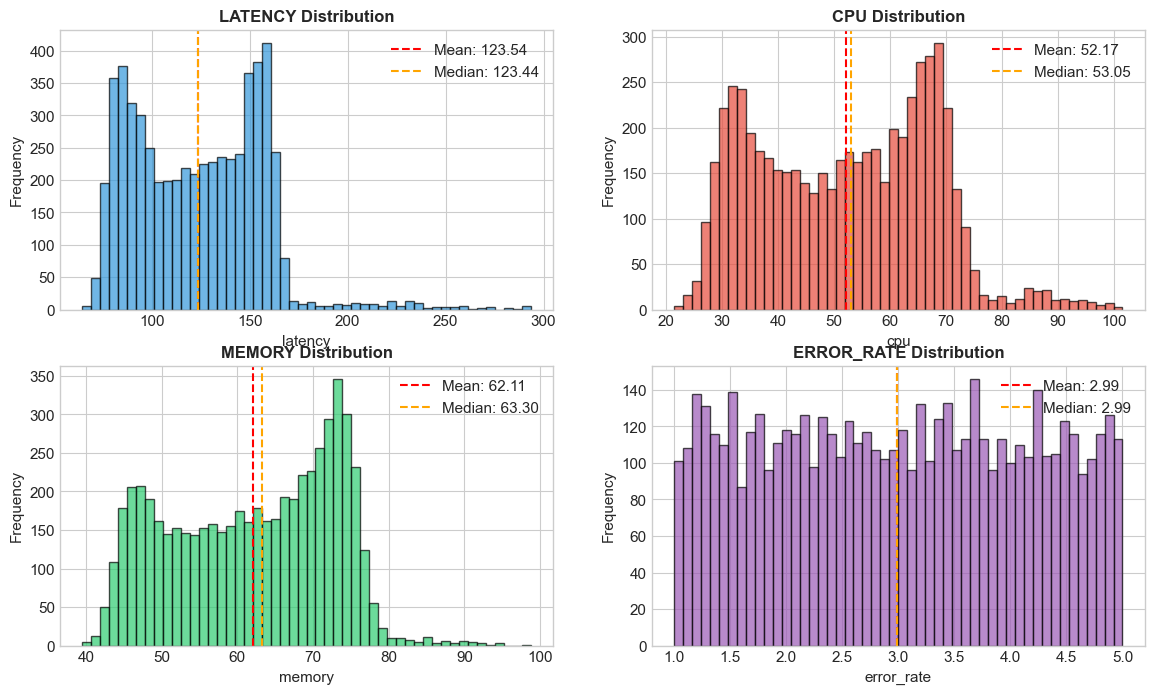

In [39]:
# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#9b59b6']

for i, col in enumerate(TARGET_METRICS):
    axes[i].hist(df[col], bins=50, color=colors[i], alpha=0.7, edgecolor='black')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    axes[i].axvline(df[col].median(), color='orange', linestyle='--', label=f'Median: {df[col].median():.2f}')
    axes[i].set_title(f'{col.upper()} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.suptitle('Distribution of Server Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

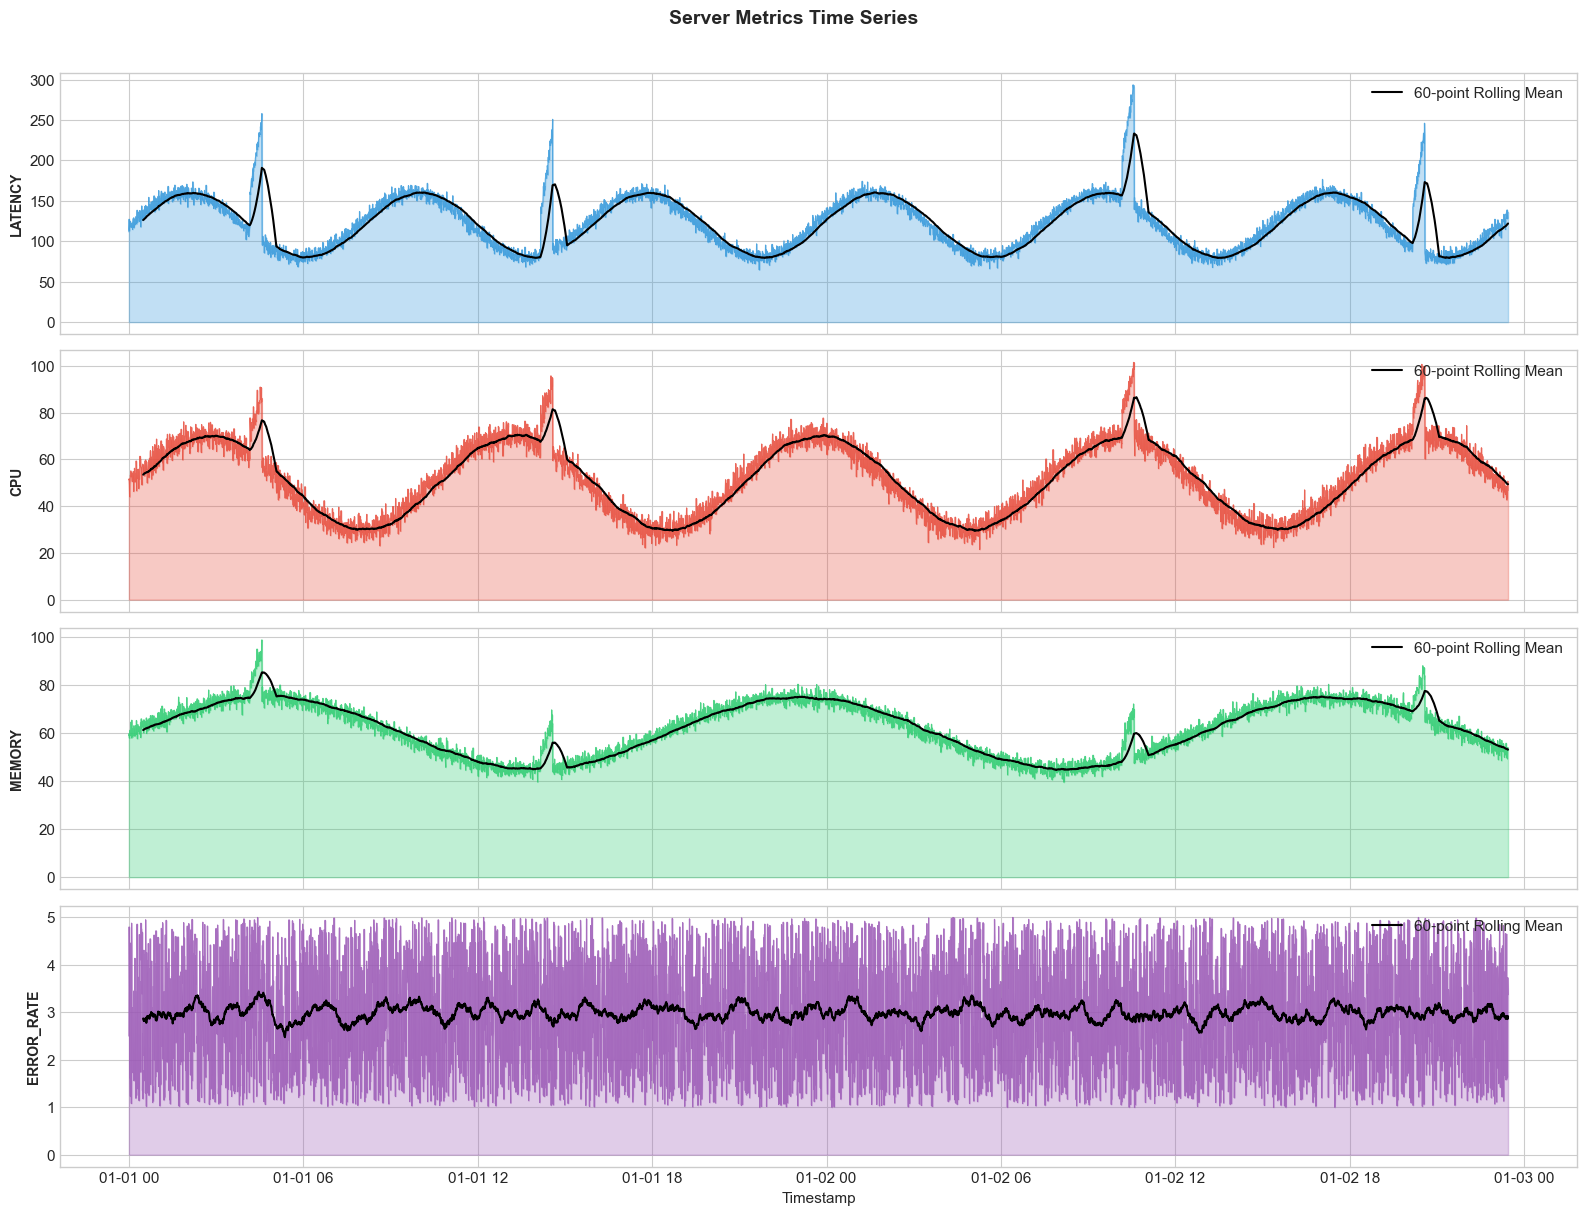

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

for i, col in enumerate(TARGET_METRICS):
    axes[i].plot(df.index, df[col], color=colors[i], linewidth=0.8, alpha=0.8)
    axes[i].set_ylabel(col.upper(), fontsize=10, fontweight='bold')
    axes[i].fill_between(df.index, df[col], alpha=0.3, color=colors[i])
    
    # Add rolling mean
    rolling_mean = df[col].rolling(window=60).mean()
    axes[i].plot(df.index, rolling_mean, color='black', linewidth=1.5, label='60-point Rolling Mean')
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Timestamp', fontsize=11)
plt.suptitle('Server Metrics Time Series', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

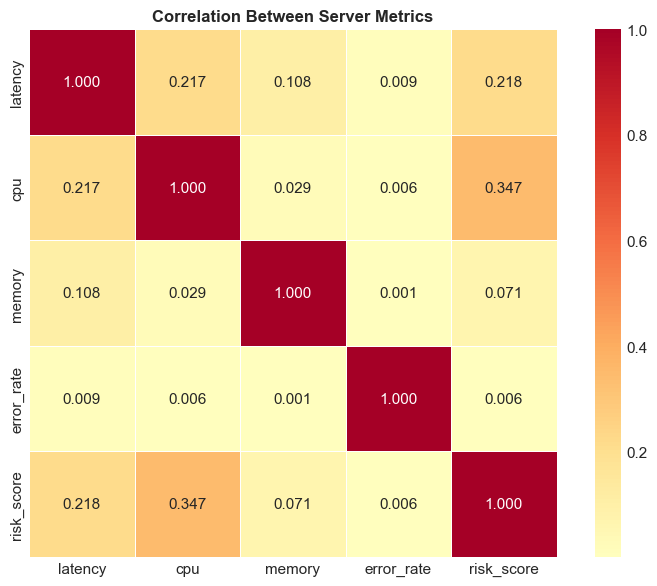

In [40]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
correlation_matrix = df[TARGET_METRICS].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, fmt='.3f', ax=ax)
ax.set_title('Correlation Between Server Metrics', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Stationarity Check (Augmented Dickey-Fuller Test)

Time series forecasting models like SARIMA require stationary data. We use the ADF test to check stationarity.

**Null Hypothesis (H0):** The time series has a unit root (non-stationary)  
**If p-value < 0.05:** Reject H0 → Series is stationary

In [41]:
def adf_test(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*50}")
    print(f"📊 ADF Test for: {name.upper()}")
    print(f"{'='*50}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Lags Used: {result[2]}")
    print(f"Observations: {result[3]}")
    
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    
    if result[1] < 0.05:
        print(f"\n✅ Result: {name} is STATIONARY (p-value < 0.05)")
        return True
    else:
        print(f"\n⚠️ Result: {name} is NON-STATIONARY (p-value >= 0.05)")
        return False

# Run ADF test for all metrics
stationarity_results = {}
for col in TARGET_METRICS:
    stationarity_results[col] = adf_test(df[col], col)



📊 ADF Test for: LATENCY
ADF Statistic: -5.1317
p-value: 0.000012
Lags Used: 3
Observations: 5690
Critical Value (1%): -3.4315
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670

✅ Result: latency is STATIONARY (p-value < 0.05)

📊 ADF Test for: CPU
ADF Statistic: -2.3782
p-value: 0.147997
Lags Used: 9
Observations: 5684
Critical Value (1%): -3.4315
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670

⚠️ Result: cpu is NON-STATIONARY (p-value >= 0.05)

📊 ADF Test for: MEMORY
ADF Statistic: -1.9748
p-value: 0.297717
Lags Used: 10
Observations: 5683
Critical Value (1%): -3.4315
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670

⚠️ Result: memory is NON-STATIONARY (p-value >= 0.05)

📊 ADF Test for: ERROR_RATE
ADF Statistic: -75.4989
p-value: 0.000000
Lags Used: 0
Observations: 5693
Critical Value (1%): -3.4315
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670

✅ Result: error_rate is STATIONARY (p-value < 0.05)

📊 ADF Test for: RISK_SCORE
ADF Statistic: -6.

## 5. Train/Test Split

We split the data into training and test sets:
- **Training set:** All data except the last 120 observations
- **Test set:** Last 120 observations (~1 hour of data at 30s intervals)


In [42]:
FORECAST_STEPS = 120  # Next 1 hour (120 * 30s = 3600s = 1 hour)
SEASONAL_PERIOD = 120  # Assuming hourly seasonality at 30s intervals

print(f"📐 Forecast Configuration:")
print(f"   • Forecast Horizon: {FORECAST_STEPS} steps")
print(f"   • Time Horizon: {FORECAST_STEPS * 30 / 60} minutes")
print(f"   • Seasonal Period: {SEASONAL_PERIOD}")
print(f"\n📊 Data Split:")
print(f"   • Total observations: {len(df)}")
print(f"   • Training set: {len(df) - FORECAST_STEPS} observations")
print(f"   • Test set: {FORECAST_STEPS} observations")

# Create train/test splits for each metric
train_data = {}
test_data = {}

for col in TARGET_METRICS:
    train_data[col] = df[col][:-FORECAST_STEPS]
    test_data[col] = df[col][-FORECAST_STEPS:]
    
print("\n✅ Train/Test split completed")

📐 Forecast Configuration:
   • Forecast Horizon: 120 steps
   • Time Horizon: 60.0 minutes
   • Seasonal Period: 120

📊 Data Split:
   • Total observations: 5694
   • Training set: 5574 observations
   • Test set: 120 observations

✅ Train/Test split completed


## 6. ARIMA Model Training

Training Seasonal ARIMA models for each metric using `auto_arima` for automatic hyperparameter selection.

**SARIMA(p,d,q)(P,D,Q,s):**
- p, d, q: Non-seasonal AR, differencing, and MA orders
- P, D, Q: Seasonal AR, differencing, and MA orders
- s: Seasonal period

In [43]:
def train_arima_model(train_series, metric_name):
    """
    Train an ARIMA model using auto_arima (non-seasonal for speed).
    """
    print(f"\n{'='*60}")
    print(f"🔧 Training ARIMA model for: {metric_name.upper()}")
    print(f"{'='*60}")
    
    model = auto_arima(
        train_series,
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        d=None,
        seasonal=False,  # Disable seasonality for speed
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        random_state=42
    )
    
    print(f"\n📋 Best Model: ARIMA{model.order}")
    print(f"   AIC: {model.aic():.2f}")
    
    return model

# Train models for all metrics
models = {}
print("🚀 Starting ARIMA Training for All Metrics...")
print("=" * 60)

for col in TARGET_METRICS:
    models[col] = train_arima_model(train_data[col], col)

print("\n" + "=" * 60)
print("✅ All models trained successfully!")


🚀 Starting ARIMA Training for All Metrics...

🔧 Training ARIMA model for: LATENCY
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38402.636, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39391.803, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38570.458, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38400.904, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39389.803, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38402.624, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38404.808, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38398.907, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38400.640, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38400.628, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38568.460, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=38402.812, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.638 se

## 7. Forecasting

In [44]:
# Generate forecasts
forecasts = {}
confidence_intervals = {}

for col in TARGET_METRICS:
    # Get forecast with confidence intervals
    forecast, conf_int = models[col].predict(
        n_periods=FORECAST_STEPS, 
        return_conf_int=True,
        alpha=0.05  # 95% confidence interval
    )
    
    # Create series with proper index
    forecasts[col] = pd.Series(forecast, index=test_data[col].index, name=f'{col}_forecast')
    confidence_intervals[col] = pd.DataFrame(
        conf_int, 
        index=test_data[col].index, 
        columns=['lower', 'upper']
    )
    
print("✅ Forecasts generated for all metrics")


✅ Forecasts generated for all metrics


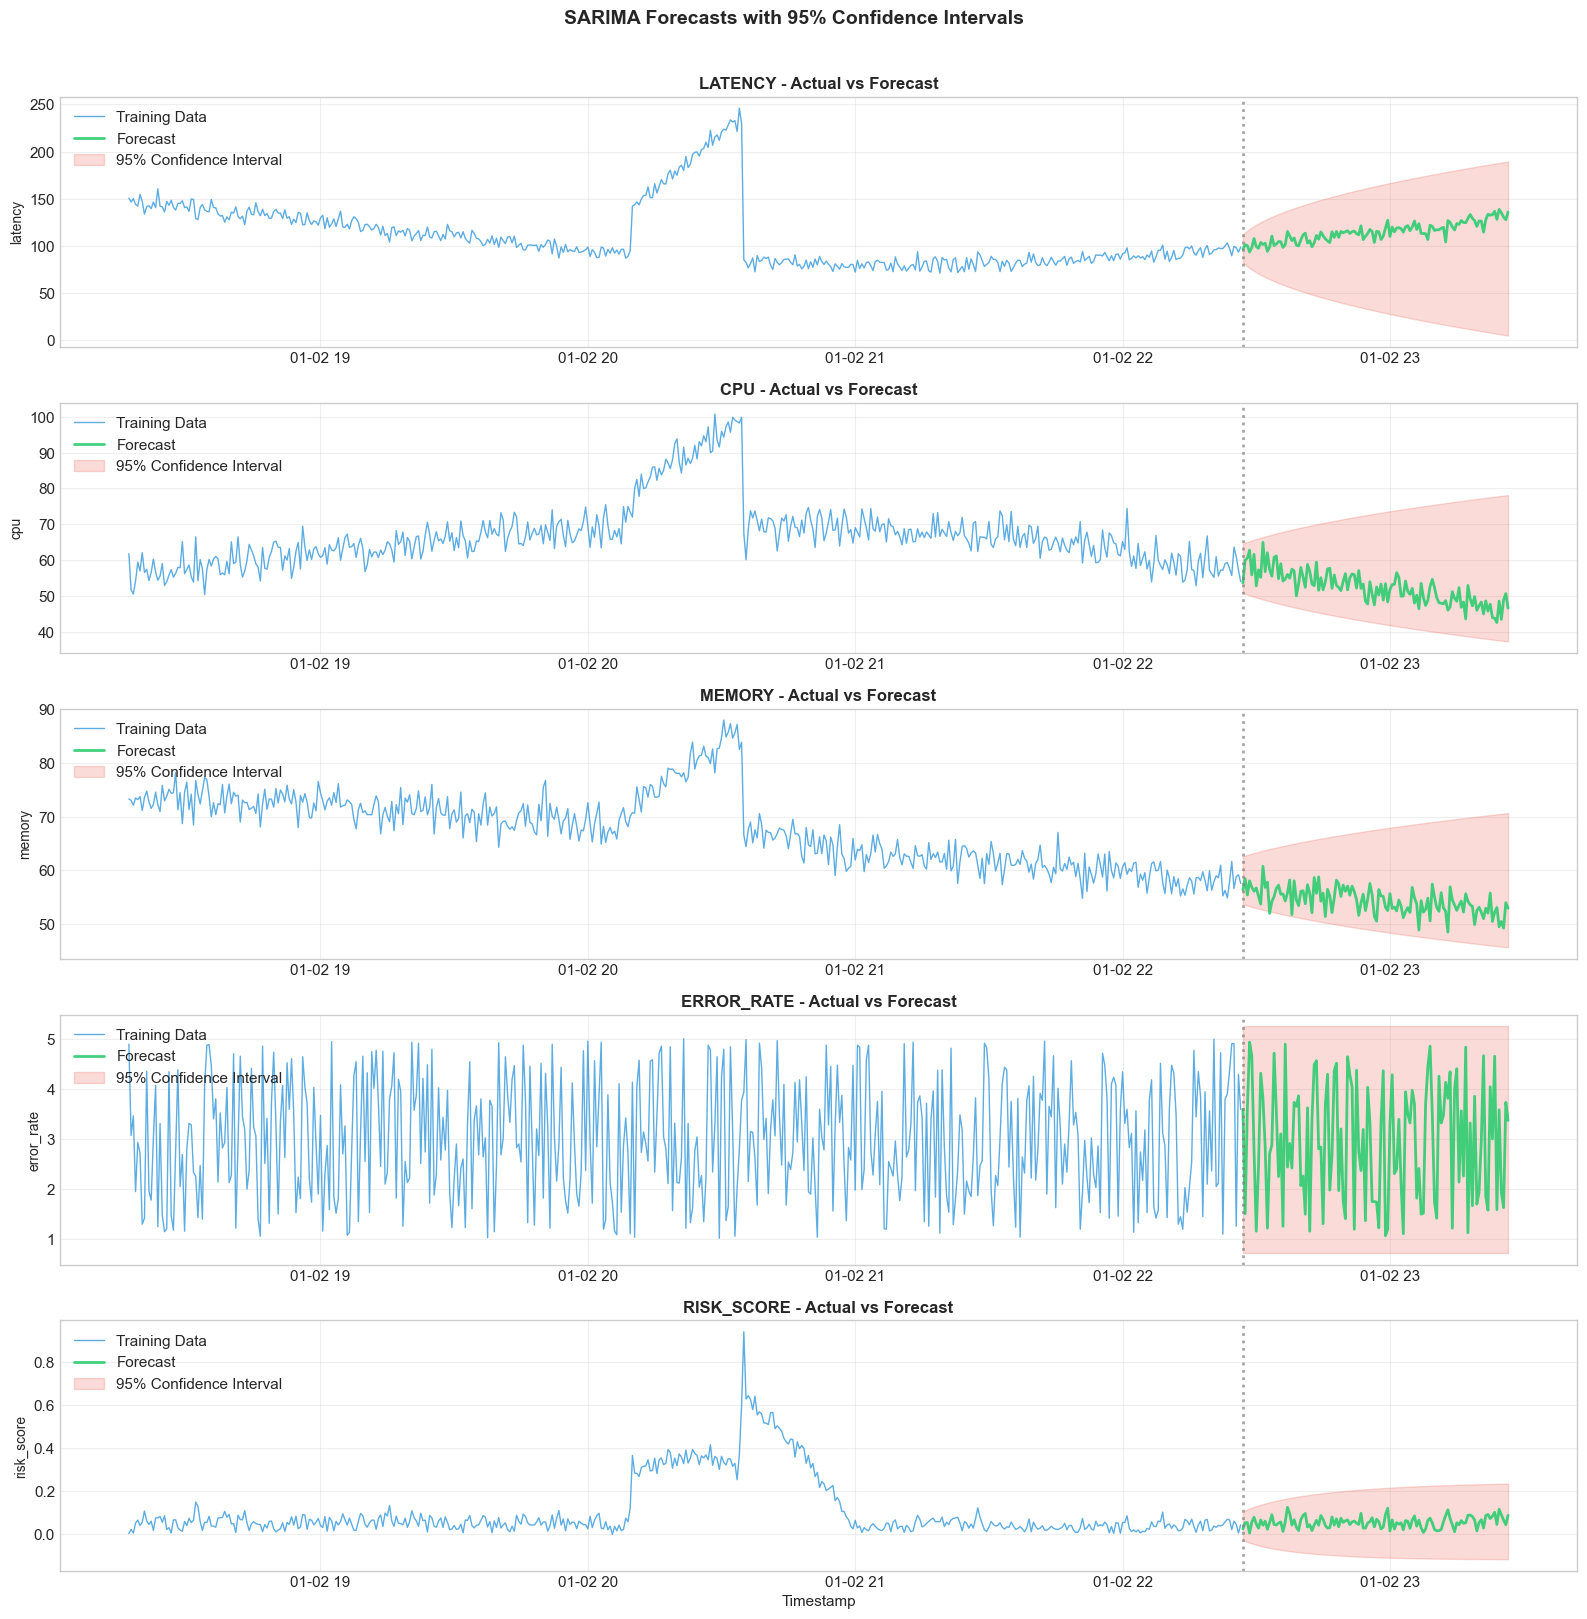

In [45]:
# Individual forecast plots with confidence intervals
fig, axes = plt.subplots(5, 1, figsize=(16, 16))

for i, col in enumerate(TARGET_METRICS):
    ax = axes[i]
    
    # Plot training data (last 500 points for visibility)
    train_plot = train_data[col][-500:]
    ax.plot(train_plot.index, train_plot.values, 
            color='#3498db', linewidth=1, label='Training Data', alpha=0.8)
    
    # Plot actual test data
    ax.plot(test_data[col].index, test_data[col].values, 
            color='#2ecc71', linewidth=2, label='Forecast', alpha=0.9)
    
  
    
    # Plot confidence interval
    ax.fill_between(
        confidence_intervals[col].index,
        confidence_intervals[col]['lower'],
        confidence_intervals[col]['upper'],
        color='#e74c3c', alpha=0.2, label='95% Confidence Interval'
    )
    
    # Vertical line at forecast start
    ax.axvline(x=test_data[col].index[0], color='gray', linestyle=':', linewidth=2, alpha=0.7)
    
    ax.set_title(f'{col.upper()} - Actual vs Forecast', fontsize=12, fontweight='bold')
    ax.set_ylabel(col, fontsize=10)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestamp', fontsize=11)
plt.suptitle('SARIMA Forecasts with 95% Confidence Intervals', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 8. Model Evaluation

Evaluating forecast accuracy using multiple metrics:
- **MAE (Mean Absolute Error):** Average magnitude of errors
- **RMSE (Root Mean Squared Error):** Penalizes larger errors
- **MAPE (Mean Absolute Percentage Error):** Percentage-based error metric

In [46]:
def calculate_metrics(actual, predicted, metric_name):
    """
    Calculate evaluation metrics for forecasts.
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Use SMAPE (Symmetric MAPE) - better for small values
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
    
    # Cap at 100%
    smape = min(smape, 100)
    accuracy = max(0, 100 - smape)
    
    return {
        'Metric': metric_name,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'SMAPE (%)': round(smape, 2),
        'Accuracy (%)': round(accuracy, 2)
    }

# Calculate metrics for all forecasts
evaluation_results = []

print("📊 Model Evaluation Results")
print("=" * 60)

for col in TARGET_METRICS:
    metrics = calculate_metrics(
        test_data[col].values, 
        forecasts[col].values, 
        col.upper()
    )
    evaluation_results.append(metrics)
    print(f"\n{col.upper()}:")
    print(f"   MAE:      {metrics['MAE']:.4f}")
    print(f"   RMSE:     {metrics['RMSE']:.4f}")
    print(f"   SMAPE:    {metrics['SMAPE (%)']:.2f}%")
    print(f"   Accuracy: {metrics['Accuracy (%)']:.2f}%")

📊 Model Evaluation Results

LATENCY:
   MAE:      17.4079
   RMSE:     20.1352
   SMAPE:    16.01%
   Accuracy: 83.99%

CPU:
   MAE:      5.9800
   RMSE:     7.0197
   SMAPE:    11.12%
   Accuracy: 88.88%

MEMORY:
   MAE:      3.8761
   RMSE:     4.4833
   SMAPE:    6.97%
   Accuracy: 93.03%

ERROR_RATE:
   MAE:      1.0113
   RMSE:     1.1492
   SMAPE:    36.47%
   Accuracy: 63.53%

RISK_SCORE:
   MAE:      0.0209
   RMSE:     0.0260
   SMAPE:    40.21%
   Accuracy: 59.79%


In [48]:
import pickle
# Save models to disk

for col in TARGET_METRICS:
    model_filename = f"{col}_arima_model.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(models[col], f)
    print(f"✅ Model for {col.upper()} saved as {model_filename}")

✅ Model for LATENCY saved as latency_arima_model.pkl
✅ Model for CPU saved as cpu_arima_model.pkl
✅ Model for MEMORY saved as memory_arima_model.pkl
✅ Model for ERROR_RATE saved as error_rate_arima_model.pkl
✅ Model for RISK_SCORE saved as risk_score_arima_model.pkl
